# 2d poissson equation
---
$$
\begin{aligned}
&\frac{d^2 u}{dx^2} + \frac{d^2 u}{dy^2} = -2\sin(x)\sin(y), \ x, y \in [-\pi, \pi]^2, \\
&u(x, -\pi) = u(x, \pi) = u(-\pi, y) = u(\pi, y) = 0.
\end{aligned}
$$

Solution:
$$
u(x) = \sin(x)\sin(y).
$$

In [1]:
import flax, flax.nn
from flax import jax_utils, optim
from flax.training import lr_schedule

import jax, jax.nn
from jax import random
import jax.numpy as jnp

import sys
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

In [2]:
class MLP(flax.nn.Module):
	def apply(self, x, layers, activation_fn):
		for l in layers[:-1]:
			x = flax.nn.Dense(x, features = l, 
							 kernel_init = jax.nn.initializers.glorot_uniform(),
							 bias_init = lambda key, shape: jnp.zeros(shape),)
			x = activation_fn(x)
		x = flax.nn.Dense(x, features = layers[-1], 
						 kernel_init = jax.nn.initializers.glorot_uniform(),
						 bias_init = lambda key, shape: jnp.zeros(shape),)
		return x
	
def create_model(key, layers):
	module = MLP.partial(layers = layers, activation_fn = jnp.tanh)
	_, initial_params = module.init_by_shape(key, [(2,)])
	model = flax.nn.Model(module, initial_params)
	return model

layers = [128, 128, 128, 128, 1]
model = create_model(random.PRNGKey(0), layers)

In [3]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def step(optimizer, batch):
	@jax.jit
	def loss_fn(model):
		
		@jax.jit
		def scalar_predict(x, y):
			return jnp.sum(model(jnp.hstack([x, y])))
        
		@jax.jit
		def scalar_du_dx(x, y):
			return jnp.sum(jax.grad(scalar_predict, 0)(x, y))
		
		@jax.jit
		def scalar_du_dy(x, y):
			return jnp.sum(jax.grad(scalar_predict, 1)(x, y))
		
		@jax.jit
		def scalar_du_dxx(x, y):
			return jnp.sum(jax.grad(scalar_du_dx, 0)(x, y))
		
		@jax.jit
		def scalar_du_dyy(x, y):
			return jnp.sum(jax.grad(scalar_du_dy, 1)(x, y))
        
		du_dxx = jax.vmap(scalar_du_dxx, in_axes = (0, 0))
		du_dyy = jax.vmap(scalar_du_dyy, in_axes = (0, 0))
		
		u_b = model(jnp.hstack([batch["b"]["x"], batch["b"]["y"]]))
		loss_c = mse(du_dxx(batch["c"]["x"], batch["c"]["y"]).reshape((-1, 1)) + du_dyy(batch["c"]["x"], batch["c"]["y"]).reshape((-1, 1)), -2*jnp.sin(batch["c"]["x"])*jnp.sin(batch["c"]["y"]))
		loss_br = mse(du_dxx(batch["b"]["x"], batch["b"]["y"]).reshape((-1, 1)) + du_dyy(batch["b"]["x"], batch["b"]["y"]).reshape((-1, 1)), -2*jnp.sin(batch["b"]["x"])*jnp.sin(batch["b"]["y"]))
		loss_bv = mse(u_b, batch["b"]["u"])
		loss = loss_c + loss_br + loss_bv
		return loss
	
	grad = jax.grad(loss_fn)(optimizer.target)
	optimizer = optimizer.apply_gradient(grad)
	return optimizer

@jax.jit
def evaluate(model, batch):
	@jax.jit
	def loss_fn(model):
		
		@jax.jit
		def scalar_predict(x, y):
			return jnp.sum(model(jnp.hstack([x, y])))
        
		@jax.jit
		def scalar_du_dx(x, y):
			return jnp.sum(jax.grad(scalar_predict, 0)(x, y))
		
		@jax.jit
		def scalar_du_dy(x, y):
			return jnp.sum(jax.grad(scalar_predict, 1)(x, y))
		
		@jax.jit
		def scalar_du_dxx(x, y):
			return jnp.sum(jax.grad(scalar_du_dx, 0)(x, y))
		
		@jax.jit
		def scalar_du_dyy(x, y):
			return jnp.sum(jax.grad(scalar_du_dy, 1)(x, y))
        
		du_dxx = jax.vmap(scalar_du_dxx, in_axes = (0, 0))
		du_dyy = jax.vmap(scalar_du_dyy, in_axes = (0, 0))
		
		u_b = model(jnp.hstack([batch["b"]["x"], batch["b"]["y"]]))
		loss_c = mse(du_dxx(batch["c"]["x"], batch["c"]["y"]).reshape((-1, 1)) + du_dyy(batch["c"]["x"], batch["c"]["y"]).reshape((-1, 1)), -2*jnp.sin(batch["c"]["x"])*jnp.sin(batch["c"]["y"]))
		loss_br = mse(du_dxx(batch["b"]["x"], batch["b"]["y"]).reshape((-1, 1)) + du_dyy(batch["b"]["x"], batch["b"]["y"]).reshape((-1, 1)), -2*jnp.sin(batch["b"]["x"])*jnp.sin(batch["b"]["y"]))
		loss_bv = mse(u_b, batch["b"]["u"])
		loss = loss_c + loss_br + loss_bv
		return loss, loss_c, loss_br, loss_bv
	return loss_fn(model)

In [4]:
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 3)
n_c = 10000
x_c = random.uniform(subkeys[0], (n_c, 1), minval = -jnp.pi, maxval = jnp.pi)
y_c = random.uniform(subkeys[1], (n_c, 1), minval = -jnp.pi, maxval = jnp.pi)

key, *subkeys = random.split(key, 5)
n_b = 100
x_b = jnp.vstack([random.uniform(subkeys[0], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*jnp.pi,
				  random.uniform(subkeys[1], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*-jnp.pi])
y_b = jnp.vstack([jnp.ones((n_b, 1))*-jnp.pi,
				  random.uniform(subkeys[2], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi),
				  jnp.ones((n_b, 1))*jnp.pi,
				  random.uniform(subkeys[3], (n_b, 1), minval = -jnp.pi, maxval = jnp.pi)])
f = lambda x, y: jnp.sin(x)*jnp.sin(y)
u_b = f(x_b, y_b)
dataset = {"c": {"x": x_c, "y": y_c},
		   "b": {"x": x_b, "y": y_b, "u": u_b}}

In [5]:
optimizer = flax.optim.Adam(learning_rate = 1e-4).create(model)
for iteration in range(1, 10001):
	optimizer = step(optimizer, dataset)
	if iteration % 1000 == 0:
		names = ("Loss", "c", "br", "bv")
		print("{}, Iteration: {},".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, evaluate(optimizer.target, dataset))]))

2020/07/21, 23:07:10, Iteration: 1000, Loss: 1.1042e-02, c: 1.8096e-03, br: 1.3218e-03, bv: 7.9102e-03
2020/07/21, 23:07:17, Iteration: 2000, Loss: 6.6375e-04, c: 2.1814e-04, br: 1.1232e-04, bv: 3.3329e-04
2020/07/21, 23:07:24, Iteration: 3000, Loss: 2.0629e-04, c: 5.1704e-05, br: 3.7026e-05, bv: 1.1756e-04
2020/07/21, 23:07:30, Iteration: 4000, Loss: 7.1009e-05, c: 2.3906e-05, br: 1.4161e-05, bv: 3.2942e-05
2020/07/21, 23:07:36, Iteration: 5000, Loss: 2.0685e-04, c: 1.9126e-05, br: 2.7412e-05, bv: 1.6032e-04
2020/07/21, 23:07:43, Iteration: 6000, Loss: 8.8688e-05, c: 1.3174e-05, br: 1.3977e-05, bv: 6.1537e-05
2020/07/21, 23:07:49, Iteration: 7000, Loss: 1.5736e-05, c: 7.3702e-06, br: 3.3672e-06, bv: 4.9988e-06
2020/07/21, 23:07:56, Iteration: 8000, Loss: 1.1422e-05, c: 5.7707e-06, br: 2.4486e-06, bv: 3.2027e-06
2020/07/21, 23:08:02, Iteration: 9000, Loss: 1.1304e-05, c: 4.7833e-06, br: 2.1847e-06, bv: 4.3361e-06
2020/07/21, 23:08:09, Iteration: 10000, Loss: 9.8991e-05, c: 9.3214e-06, 

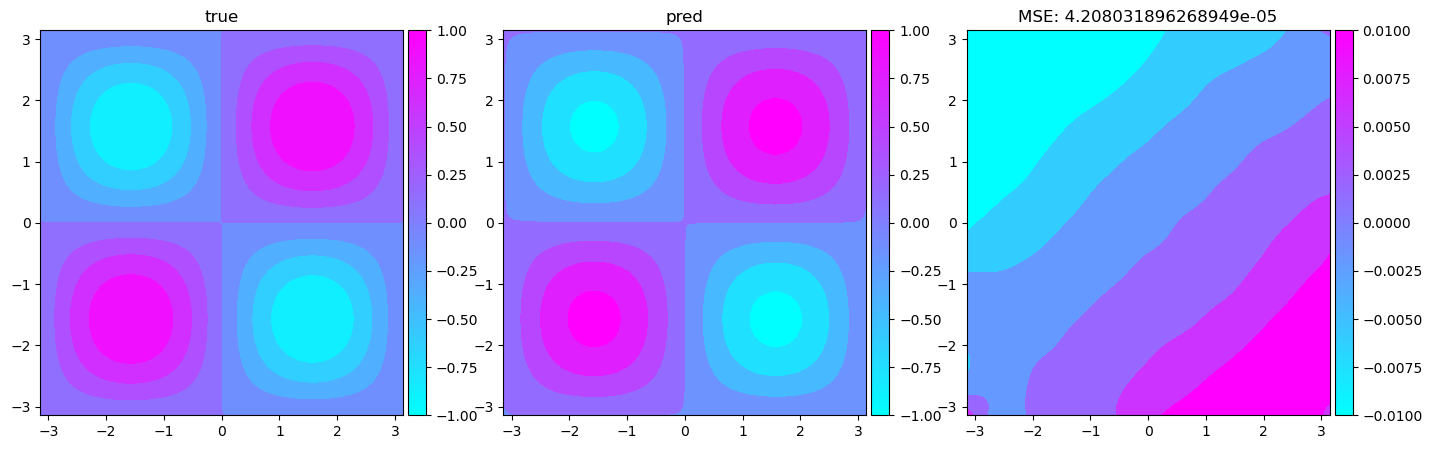

In [6]:
x_test = jnp.linspace(-jnp.pi, jnp.pi, 100).reshape((-1, 1))
y_test = x_test
xy_test = tensor_grid([x_test, y_test])

u_pred = optimizer.target(xy_test)
u_test = f(xy_test[:, 0:1], xy_test[:, 1:2])


import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

cmap = cool
norm = Normalize(vmin=-1.0, vmax=1.0)

X, Y = np.meshgrid(x_test, y_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Y, u_test.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
im1 = ax[1].contourf(X, Y, u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Y, u_test.reshape((len(y_test), len(x_test)))-u_pred.reshape((len(y_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("MSE: {}".format(np.mean(np.square(u_test - u_pred))))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()